In [99]:
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.datasets import *
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import math
import time

from sklearn import cluster, datasets

from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import pairwise_distances


%matplotlib inline


pylab.rcParams['figure.figsize'] = 16, 12

In [2]:
os.chdir('F:\Spring2016\NonParametricEstimation\project\implementation')

# Utility Code

In [85]:
def read_data(filename):
    data=np.genfromtext(filename)
    return data
def euc_distance(x,xi):
    if len(x)!=len(xi):
        print 'len_x {}, len_xi'.format(len(x),len(xi))
        raise Exception('Dimensions do not match')
    return np.sqrt(np.sum((x-xi)**2))

def gaussian_kernel(distance, bandwidth):
    val = (1/(bandwidth*math.sqrt(2*math.pi))) * np.exp(-0.5*((distance / bandwidth))**2)
    return val

def minkowski_distance(x,xi,ind,p=2):
    if len(x)!=len(xi):
            raise Exception('Dimensions do not match')
    return np.power(np.sum((x[ind]-xi[ind])**p),1.0/p)
    


def get_neighbors(pts, centroid, threshold_distance=5, k=-1):
    neighbors=[]
    count=0
    for pt in pts:
        dist=euc_distance(pt, centroid)
        if dist<=threshold_distance:
            neighbors.append(pt)
            count+=1
            if k!=-1 and count>=k: # Adding support for the adaptive bandwidth selection
                break
    return neighbors

def get_dispersion_weights(neighbors, len_features):
    dispersion_weights=np.zeros(len_features)
    for k in range(len_features):
        for i in neighbors:
            for j in neighbors:
                dispersion_weights[k]+=minkowski_distance(i,j,k)
    denom=np.sum(dispersion_weights)
    dispersion_weights=dispersion_weights/denom
    return dispersion_weights

# Mean Shift Base Class

In [123]:

class custom_mean_shift():
    def __init__(self, no_iterations=50, kernel_bandwidth=4, threshold_distance=5, features_weighting=False):
        self.threshold_distance = 5
        self.kernel_bandwidth=kernel_bandwidth
        self.no_iterations=no_iterations
        self.threshold_distance=threshold_distance
        self.cluster_centers_=[]
        self.features_weighting=features_weighting
        
    def fit(self,sample_data):
        no_iterations=self.no_iterations
        kernel_bandwidth=self.kernel_bandwidth
        threshold_distance=self.threshold_distance
        datacopy=np.copy(sample_data)
        past_iterations_data=[]
#         if self.features_weighting:
#             datacopy=datacopy*get_dispersion_weights(sample_data.shape[1])

        for it in range(no_iterations): # The converegence criteria should be distance based
            print 'iteration', it
            for i,currentX in enumerate(datacopy):
                # Step 1 get neighborhood points for each point X
                neighbors = get_neighbors(datacopy, currentX, threshold_distance)#neighbourhood_points
                #neighbors = neighbourhood_points(datacopy, currentX, threshold_distance)
                # To make get_neighbors adaptive pass the argument k to it
    #             dispersion_weights=get_dispersion_weights(neighbors)
                numerator=0.001
                denominator=0.001
                if self.features_weighting:
                    weight2=get_dispersion_weights(neighbors,sample_data.shape[1])
                for  neighborX in neighbors:
                    dist=euc_distance(currentX,neighborX)
                    
                    weight=gaussian_kernel(dist, kernel_bandwidth)
                    if self.features_weighting:
                        weight*=weight2
                    numerator+=((weight+0.001)*neighborX)
                    denominator+=(weight+0.001)

                mean_x=numerator/denominator
                datacopy[i]=mean_x
            past_iterations_data.append(np.copy(datacopy))

        #clusters=[[round(each[0],2),round(each[1],2)] for each in datacopy]
        clusters=datacopy.round(2).tolist()
        clusters=list(set([tuple(row) for row in clusters]))
        self.cluster_centers_=np.copy(clusters)
        self.past_iterations_data=past_iterations_data
        
    def predict(self,sample_data):
#         print 'Inside predict , Length of cluster_centers_ {}'.format(len(self.cluster_centers_))
        cluster_assignment=np.zeros(len(sample_data))
        for ind,each in enumerate(sample_data):
            cluster_id=0
            min_dist=1000
            for i,clust in enumerate(self.cluster_centers_):
                current_distance=euc_distance(clust,each)
#                 print 'point {}, cluster_id {}, distance {}'.format(ind,i,current_distance)
                if current_distance<=min_dist:
                    min_dist=current_distance
                    cluster_id=i
            cluster_assignment[ind]=cluster_id
        return  cluster_assignment
    

# Experiment 1 : Working of Mean Shift

In [124]:
# Creating Synthetic Data
sample_data,_  = make_blobs(100, 2, centers=4, cluster_std=1.3)
sample_data.shape


(100L, 2L)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


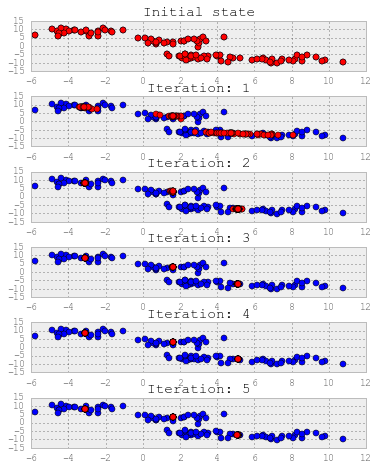

In [128]:
no_iterations=5
cms=custom_mean_shift(no_iterations=no_iterations)
cms.fit(sample_data)
# print cms.cluster_centers_
y=cms.predict(sample_data)
past_iterations_data=cms.past_iterations_data
figure = plt.figure(1)
figure.set_size_inches((6, 9))
plt.subplot(no_iterations + 2, 1, 1)
plt.title('Initial state')
plt.plot(sample_data[:,0], sample_data[:,1], 'bo')
plt.plot(sample_data[:,0], sample_data[:,1], 'ro')

for i in range(no_iterations):
    figure_index = i + 2
    plt.subplot(no_iterations + 2, 1, figure_index)
    plt.title('Iteration: %d' % (figure_index - 1))
    plt.plot(sample_data[:,0], sample_data[:,1], 'bo')
    plt.plot(past_iterations_data[i][:,0], past_iterations_data[i][:,1], 'ro')



# Experiment 2: Working on Synthetic Data

In [127]:
# Creating datasets
rand_seed=1234
np.random.seed(rand_seed)
def generate_datasets(no_samples=150):
    noisy_circles=sklearn.datasets.make_circles(n_samples=no_samples,factor=0.5,noise=0.5)
    noisy_moons=sklearn.datasets.make_moons(n_samples=no_samples,noise=0.5)
    blobs=sklearn.datasets.make_blobs(no_samples,random_state=rand_seed)
    no_structure=np.random.rand(no_samples,2),None
    
    return noisy_circles, noisy_moons, blobs, no_structure

In [ ]:
noisy_circles,noisy_moons, blobs, no_structure=generate_datasets(100)
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)
clustering_names = [
     'CustomMeanShift','CustomMeanShift2','CustomMeanShift3'
    ]


In [ ]:
plt.figure(figsize=(len(clustering_names) * 2 + 3, 15.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

datasets = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)
    print bandwidth
    

    # create clustering estimators
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    cms=custom_mean_shift(kernel_bandwidth=bandwidth)
    cms2=custom_mean_shift(kernel_bandwidth=bandwidth, threshold_distance=2)
    cms3=custom_mean_shift(kernel_bandwidth=bandwidth, features_weighting=True)
    
    clustering_algorithms = [
         cms,cms2,cms3
    ]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
            #print y_pred
        else:
            y_pred = algorithm.predict(X).astype(np.int)
            #print y_pred

        # plot
        plt.subplot(4, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            print 'name {}, centers {}'.format(name, centers)
#             sd=metrics.silhouette_score(X, y_pred, metric='euclidean')
#             print 'name {}, centers {}, sd{}'.format(name, centers, sd)
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black')
            
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=12,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

# Experimenting with Higher Dimensions

In [83]:
blobs_list=[]
j=10
while(j<=100):
    blobs_list.append(sklearn.datasets.make_blobs(n_features=j,random_state=rand_seed))
    j+=10

In [ ]:

datasets = blobs_list
for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.35)
    print bandwidth
    

    # create clustering estimators
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    cms=custom_mean_shift(kernel_bandwidth=bandwidth)
    cms2=custom_mean_shift(kernel_bandwidth=bandwidth, threshold_distance=2)
    cms3=custom_mean_shift(kernel_bandwidth=bandwidth, features_weighting=True)
    
    clustering_algorithms = [
         ms,cms,cms2,cms3
    ]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
            #print y_pred
        else:
            y_pred = algorithm.predict(X).astype(np.int)
            #print y_pred


        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            h,c,v=metrics.homogeneity_completeness_v_measure(y, y_pred)
            print 'name {},  homogenity {}, completeness {}, v_score {}'.format(name, h,c,v)
            try:
                print 'name {}, silhouette score {}'.format(name,metrics.silhouette_score(X, y, metric='euclidean'))
            except:
                pass

            center_colors = colors[:len(centers)]


# Performance on Real World Twitter Data

In [103]:
# Twitter Data

df=pd.read_csv('npm_gender.csv',index_col=0)
df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,id_str,mt_coded_sex
0,11,0,28,12,34,9,9,1,7,13,...,15,51,15,4,27,20,10,21,235996827,Female


In [110]:
X=df[[each for each in df.columns if 'id' not in each and 'mt' not in each]]
X=X.as_matrix()
y=np.where(df['mt_coded_sex']=='Male',1,0)
y

array([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1])

In [ ]:

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=0.45)
print bandwidth


# create clustering estimators

cms=custom_mean_shift(kernel_bandwidth=bandwidth)
cms2=custom_mean_shift(kernel_bandwidth=bandwidth, threshold_distance=5)
cms3=custom_mean_shift(kernel_bandwidth=bandwidth, features_weighting=True)

clustering_algorithms = [
     cms,cms2,cms3
]

for name, algorithm in zip(clustering_names, clustering_algorithms):
    # predict cluster memberships
    t0 = time.time()
    algorithm.fit(X)
    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
        #print y_pred
    else:
        y_pred = algorithm.predict(X).astype(np.int)

    if hasattr(algorithm, 'cluster_centers_'):
        centers = algorithm.cluster_centers_
        h,c,v=metrics.homogeneity_completeness_v_measure(y, y_pred)
        print 'name {},  homogenity {}, completeness {}, v_score {}'.format(name, h,c,v)
        try:
            print 'name {}, silhouette score {}'.format(name,metrics.silhouette_score(X, y, metric='euclidean'))
        except:
            pass

        center_colors = colors[:len(centers)]
#           